<a href="https://colab.research.google.com/github/ok69531/AAIS-public/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Clone the repository and install packages

In [1]:
!git clone https://github.com/ok69531/AAIS-public.git

fatal: destination path 'AAIS-public' already exists and is not an empty directory.


In [ ]:
pip install torch_geometric rdkit ogb

In [5]:
# change current directory
import os

os.getcwd()
os.chdir('AAIS-public')

'/content/AAIS-public'

### Import modules

In [6]:
# import modules
import torch
from torch import optim

import torch_geometric
from torch_geometric.loader import DataLoader
from ogb.graphproppred import PygGraphPropPredDataset

from module.set_seed import set_seed
from module.argument import get_parser
from module.model import GNNGraphPred
from module.train import train, aais_sgd_train, aais_adam_train, evaluation

import numpy as np
from copy import deepcopy

### Load arguments

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

parser = get_parser()
try:
    args = parser.parse_args()
except:
    args = parser.parse_args([])

args.dataset = 'clintox' # multi-task dataset
args.num_workers = 0
args.train_type = 'aais'

if args.dataset == "tox21":
    num_task = 12
elif args.dataset == "hiv":
    num_task = 1
elif args.dataset == "bace":
    num_task = 1
elif args.dataset == "bbbp":
    num_task = 1
elif args.dataset == "toxcast":
    num_task = 617
elif args.dataset == "sider":
    num_task = 27
elif args.dataset == "clintox":
    num_task = 2

print(f'Device: {device}')
print(args)

Device: cuda:0
Namespace(num_runs=10, batch_size=32, epochs=100, lr=0.001, lr_scale=1, num_layer=5, emb_dim=300, dropout_ratio=0.5, graph_pooling='mean', JK='last', gnn_type='gcn', ratio=0.5, m=3, step_size=0.001, max_pert=0.01, burn=20, dataset='clintox', num_workers=0, virtual=False, residual=False, train_type='aais', optim_method='sgd')


usage: colab_kernel_launcher.py [-h] [--num_runs NUM_RUNS] [--batch_size BATCH_SIZE]
                                [--epochs EPOCHS] [--lr LR] [--lr_scale LR_SCALE]
                                [--num_layer NUM_LAYER] [--emb_dim EMB_DIM]
                                [--dropout_ratio DROPOUT_RATIO] [--graph_pooling GRAPH_POOLING]
                                [--JK JK] [--gnn_type GNN_TYPE] [--ratio RATIO] [--m M]
                                [--step_size STEP_SIZE] [--max_pert MAX_PERT] [--burn BURN]
                                [--dataset DATASET] [--num_workers NUM_WORKERS]
                                [--virtual VIRTUAL] [--residual RESIDUAL]
                                [--train_type TRAIN_TYPE] [--optim_method OPTIM_METHOD]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-502c39ff-855d-4526-8c67-ba16ea5f08de.json


### Data preparation

In [14]:
dataset = PygGraphPropPredDataset(name = f'ogbg-mol{args.dataset}', root = 'dataset')
split_idx = dataset.get_idx_split()

train_loader = DataLoader(dataset[split_idx['train']], batch_size = args.batch_size, shuffle = True, num_workers = args.num_workers)
val_loader = DataLoader(dataset[split_idx['valid']], batch_size = args.batch_size, shuffle = False, num_workers = args.num_workers)
test_loader = DataLoader(dataset[split_idx['test']], batch_size = args.batch_size, shuffle = False, num_workers = args.num_workers)

In [11]:
for _, batch in enumerate(train_loader):
  batch = batch.to(device)
  break

batch # batch contains 32 graphs

DataBatch(edge_index=[2, 1526], edge_attr=[1526, 3], x=[732, 9], y=[32, 2], num_nodes=732, batch=[732], ptr=[33])

### Model

In [20]:
seed = 0
set_seed(seed)
torch_geometric.seed_everything(seed)

model = GNNGraphPred(num_tasks = num_task, num_layer = args.num_layer, emb_dim = args.emb_dim,
                    gnn_type = args.gnn_type,
                    graph_pooling = args.graph_pooling, drop_ratio = args.dropout_ratio, JK = args.JK,
                    virtual_node = args.virtual, residual = args.residual)
model = model.to(device)

if args.optim_method == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr = args.lr)
elif args.optim_method == 'adam':
    iteration = 0
    first_moment = 0.
    second_moment = 0.
    optimizer = optim.Adam(model.parameters(), lr = args.lr)

criterion = torch.nn.BCEWithLogitsLoss(reduction = 'sum')

print(model)
print(optimizer)

Random seed set as 0
GNNGraphPred(
  (gnn): GNN(
    (atom_encoder): AtomEncoder(
      (atom_embedding_list): ModuleList(
        (0): Embedding(119, 300)
        (1): Embedding(5, 300)
        (2-3): 2 x Embedding(12, 300)
        (4): Embedding(10, 300)
        (5-6): 2 x Embedding(6, 300)
        (7-8): 2 x Embedding(2, 300)
      )
    )
    (gnns): ModuleList(
      (0-4): 5 x GCNConv()
    )
    (batch_norms): ModuleList(
      (0-4): 5 x BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=300, out_features=2, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### One-step influence function

In [12]:
def flat_grad(grad_list):
    gradient = torch.cat([x.view(-1) for x in grad_list])
    return gradient


def sample_in_batch(batch, i):
    one_sample = batch[i]

    x = one_sample.x
    edge_attr = one_sample.edge_attr
    edge_index = one_sample.edge_index
    y = one_sample.y
    b = torch.zeros(one_sample.num_nodes).to(torch.int64).to(x.device)

    return (x, edge_attr, edge_index, b, y)


def compute_lin_sample_grad(model, embedding, target, criterion):
    model.eval()

    embedding = embedding.unsqueeze(0)
    pred = model(embedding).to(torch.float32)

    y = target.view(pred.shape).to(torch.float32)
    is_labeled = y==y
    loss = criterion(pred[is_labeled], y[is_labeled])

    return torch.autograd.grad(loss, model.parameters())


def sgd_lin_if(model, batch, criterion, args):
    model.eval()

    eta = args.lr

    embeddings = model.pool(model.gnn(batch), batch.batch)
    targets = batch.y

    sample_grads = torch.stack([flat_grad(compute_lin_sample_grad(model.graph_pred_linear, embeddings[i], targets[i], criterion)) for i in range(len(embeddings))])

    sample_influence = []
    for i in range(sample_grads.size(0)):
        if_tmp = torch.abs(eta * sample_grads[i].dot(sample_grads[i]))
        sample_influence.append(if_tmp)
    sample_influence = torch.stack(sample_influence)

    return sample_influence


In [21]:
# influence value of per samples
sgd_lin_if(model, batch, criterion, args)

tensor([0.0132, 0.0156, 0.0148, 0.0154, 0.0142, 0.0137, 0.0133, 0.0134, 0.0136,
        0.0158, 0.0145, 0.0207, 0.0207, 0.0258, 0.0141, 0.0153, 0.0141, 0.0132,
        0.0145, 0.0199, 0.0132, 0.0126, 0.0140, 0.0138, 0.0151, 0.0153, 0.0143,
        0.0150, 0.0175, 0.0141, 0.0142, 0.0211], device='cuda:0')

### AAIS train function

In [22]:
def aais_sgd_train(model, device, loader, criterion, optimizer, args):
    model.train()

    # arguments
    m = args.m
    emb_dim = args.emb_dim
    ratio = args.ratio
    max_pert = args.max_pert
    step_size = args.step_size

    for step, batch in enumerate(loader):
        batch = batch.to(device)

        if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
            pass
        else:
            optimizer.zero_grad()

            # number of data to apply augmentation
            k = int(len(batch.y) * ratio)

            # influence value of per samples
            loo_influence = sgd_lin_if(model, batch, criterion, args)

            # choose top-k samples
            _, topk_idx = torch.topk(loo_influence, k = k, axis = -1)
            low_idx = [i for i in range(len(batch.y)) if i not in topk_idx]

            # perturbation initialize
            perturb = torch.FloatTensor(k, emb_dim).uniform_(-max_pert, max_pert).to(device)
            perturb.requires_grad_()

            y = batch.y
            is_labeled = y == y # ignore nan targets (unlabeled) when computing training loss.

            # perturbation update
            for _ in range(m-1):
                graph_embedding = model.pool(model.gnn(batch), batch.batch)[topk_idx, :]
                graph_embedding = graph_embedding + perturb

                pred = model.graph_pred_linear(graph_embedding)

                topk_y = y[topk_idx]
                topk_is_labeled = topk_y == topk_y

                loss = 0
                loss = criterion(pred.to(torch.float32)[topk_is_labeled], topk_y.to(torch.float32)[topk_is_labeled])
                loss = loss / (torch.sum(is_labeled) * m)
                loss.backward() # cumulate the gradients

                perturb_data = perturb.detach() + step_size * torch.sign(perturb.grad.detach())
                perturb.data = perturb_data.data
                perturb.grad[:] = 0

            graph_embedding = model.pool(model.gnn(batch), batch.batch)

            topk_graph_embedding = graph_embedding[topk_idx, :] + perturb
            low_graph_embedding = graph_embedding[low_idx, :]

            low_y = y[low_idx]
            low_is_labeled = low_y == low_y

            topk_pred = model.graph_pred_linear(topk_graph_embedding)
            low_pred = model.graph_pred_linear(low_graph_embedding)

            loss = 0
            topk_loss = criterion(topk_pred.to(torch.float32)[topk_is_labeled], topk_y.to(torch.float32)[topk_is_labeled])
            low_loss = criterion(low_pred.to(torch.float32)[low_is_labeled], low_y.to(torch.float32)[low_is_labeled])

            topk_loss = topk_loss / (torch.sum(is_labeled) * m)
            low_loss = topk_loss / (torch.sum(is_labeled))

            loss = topk_loss + low_loss

            loss.backward()
            optimizer.step() # parameter update

In [23]:
aais_sgd_train(model, device, train_loader, criterion, optimizer, args)

### Training loop

In [24]:
criterion = torch.nn.BCEWithLogitsLoss(reduction = 'sum')

auc_vals, auc_tests = [], []
f1_vals, f1_tests = [], []

seed = 0
set_seed(seed)
torch_geometric.seed_everything(seed)

best_val_auc, final_test_auc = 0, 0
best_val_f1, final_test_f1 = 0, 0

model = GNNGraphPred(num_tasks = num_task, num_layer = args.num_layer, emb_dim = args.emb_dim,
                    gnn_type = args.gnn_type,
                    graph_pooling = args.graph_pooling, drop_ratio = args.dropout_ratio, JK = args.JK,
                    virtual_node = args.virtual, residual = args.residual)
model = model.to(device)


if args.optim_method == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr = args.lr)
elif args.optim_method == 'adam':
    iteration = 0
    first_moment = 0.
    second_moment = 0.
    optimizer = optim.Adam(model.parameters(), lr = args.lr)


for epoch in range(1, args.epochs + 1):
    if (args.train_type == 'aais') & (args.optim_method == 'sgd'):
        if epoch <= args.burn:
            train(model, device, train_loader, criterion, optimizer)
        else:
            aais_sgd_train(model, device, train_loader, criterion, optimizer, args)
    elif (args.train_type == 'aais') & (args.optim_method == 'adam'):
        if epoch <= args.burn:
            train(model, device, train_loader, criterion, optimizer)
        else:
            iteration, first_moment, second_moment = aais_adam_train(model, device, train_loader, criterion, optimizer, args, iteration, first_moment, second_moment)

    train_loss, train_auc, train_f1 = evaluation(model, device, train_loader, criterion, args)
    val_loss, val_auc, val_f1 = evaluation(model, device, val_loader, criterion, args)
    test_loss, test_auc, test_f1 = evaluation(model, device, test_loader, criterion, args)

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        best_val_f1 = val_f1
        final_test_f1 = test_f1

        best_epoch = epoch
        model_params = deepcopy(model.state_dict())

    if epoch % 10 == 0:
        print(f'=== epoch {epoch}')
        print(f'train loss: {train_loss:.4f}, train auc: {train_auc*100:.2f}')
        print(f'val loss: {val_loss:.4f}, val auc: {val_auc*100:.2f}')
        print(f'test loss: {test_loss:.4f}, test auc: {test_auc*100:.2f}')


Random seed set as 0
=== epoch 10
train loss: 0.7590, train auc: 48.89
val loss: 0.7674, val auc: 36.94
test loss: 0.7636, test auc: 43.10
=== epoch 20
train loss: 0.7630, train auc: 51.33
val loss: 0.7726, val auc: 38.21
test loss: 0.7685, test auc: 45.06
=== epoch 30
train loss: 0.5818, train auc: 75.12
val loss: 0.5683, val auc: 75.31
test loss: 0.5901, test auc: 72.08
=== epoch 40
train loss: 0.5804, train auc: 85.34
val loss: 0.5711, val auc: 87.37
test loss: 0.5929, test auc: 78.48
=== epoch 50
train loss: 0.5642, train auc: 87.38
val loss: 0.5495, val auc: 92.18
test loss: 0.5816, test auc: 82.25
=== epoch 60
train loss: 0.5612, train auc: 90.97
val loss: 0.5455, val auc: 96.78
test loss: 0.5868, test auc: 84.37
=== epoch 70
train loss: 0.5588, train auc: 92.69
val loss: 0.5435, val auc: 96.67
test loss: 0.5884, test auc: 85.72
=== epoch 80
train loss: 0.5439, train auc: 94.05
val loss: 0.5291, val auc: 97.37
test loss: 0.5664, test auc: 86.70
=== epoch 90
train loss: 0.5437, tr

### Appendix - Plotting the top-k influential data

In [28]:
model.load_state_dict(model_params)
model.eval()

train_y = []
test_y = []
train_embedding = []
test_embedding = []
train_influence = []
test_influence = []

for _, batch in enumerate(train_loader):
    batch = batch.to(device)
    train_y.append(batch.y[:, 1])
    train_embedding.append(model.pool(model.gnn(batch), batch.batch))
    train_influence.append(sgd_lin_if(model, batch, criterion, args))

for _, batch in enumerate(test_loader):
    batch = batch.to(device)
    test_y.append(batch.y[:, 1])
    test_embedding.append(model.pool(model.gnn(batch), batch.batch))
    test_influence.append(sgd_lin_if(model, batch, criterion, args))

train_y = torch.cat(train_y).view(-1).cpu().numpy()
train_embedding = torch.cat(train_embedding).detach().cpu().numpy()
train_influence = torch.cat(train_influence).cpu()

test_y = torch.cat(test_y).view(-1).cpu().numpy()
test_embedding = torch.cat(test_embedding).detach().cpu().numpy()
test_influence = torch.cat(test_influence).cpu()

<ipython-input-29-0b6fd88cb7df>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, topk_idxs = torch.topk(torch.tensor(train_influence), train_top_k)


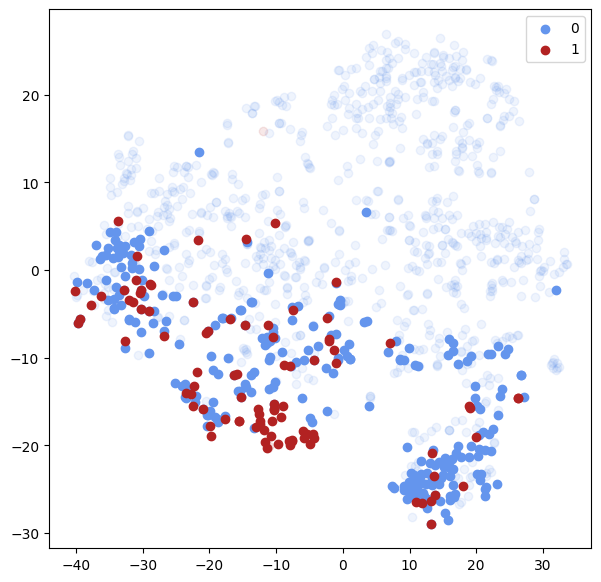

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components = 2, random_state = 0, perplexity = 50)
train_tsne = tsne.fit_transform(train_embedding)

train_top_k = int(len(train_y) * 0.3)
_, topk_idxs = torch.topk(torch.tensor(train_influence), train_top_k)
low_idxs = np.array([i for i in range(len(train_y)) if i not in topk_idxs])

cdict = {0: 'cornflowerblue', 1: 'firebrick'}

fig, ax = plt.subplots(figsize = (7, 7))

for g in np.unique(train_y):
    idx = np.where(train_y[low_idxs] == g)[0]
    ax.scatter(train_tsne[low_idxs][idx][:, 0], train_tsne[low_idxs][idx][:, 1], label = '_nolgend_', c = cdict[g], alpha = 0.1)

for g in np.unique(train_y):
    idx = np.where(train_y[topk_idxs] == g)[0]
    ax.scatter(train_tsne[topk_idxs][idx][:, 0], train_tsne[topk_idxs][idx][:, 1], c = cdict[g], label = g)

plt.legend()
plt.show()
plt.close()


- While the dimensions are not neatly separated for each label, data points with high influence primarily appear in regions where major and minor labels overlap.